In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem 

import matplotlib.pyplot as plt

# Cell State

In [3]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    division:           jax.Array
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array

In [4]:
N_DIM = 2
N_CHEM = 20
N_HIDDEN = 150
N_CTYPES = 1

N = 130
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,N_CTYPES)).at[0].set(1.),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN)),
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [5]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=.1),
        # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=1., diffusion_coeff=2.),

        jxm.cell.sensing.LocalChemicalGradients(),

        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=0.,
                            degradation_init=jax.nn.initializers.constant(1.),
                            interaction_init=jax.nn.initializers.normal(.1),
                            ),
    ])

In [6]:
EPOCHS = 200
N_EPISODES = 4
N_VAL_EPISODES = 16

COST_FN = jxm.opt.cost_functions.VShape(cost_per_cell=1, rew_per_cell=3, nonsymm_penalty=.1)

GAMMA = .9
LAMBDA = .1

LOSS = jxm.opt.losses.ReinforceLoss(COST_FN,
                                    n_sim_steps=N_ADD,
                                    n_episodes=N_EPISODES,
                                    n_val_episodes=N_VAL_EPISODES,
                                    gamma=GAMMA,
                                    lambda_l1=LAMBDA,
                                    normalize_cost_returns='batch'
                                    )


opt_results = jxm.opt.train(model, istate, LOSS, key=key, epochs=EPOCHS)

Loss: -226.37261: 100%|███████████████████████| 200/200 [07:19<00:00,  2.20s/it]


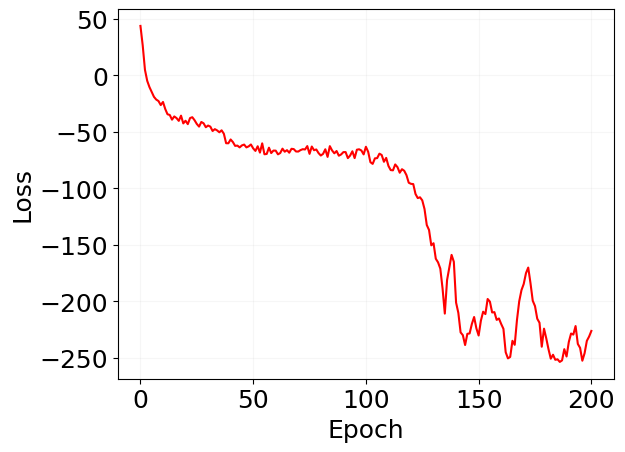

In [7]:
plt.plot(opt_results.loss_aux, 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.1);

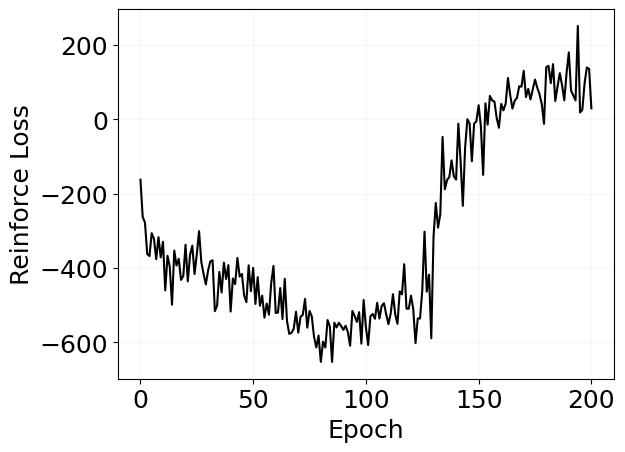

In [8]:
plt.plot(opt_results.loss, 'k')

plt.xlabel('Epoch')
plt.ylabel('Reinforce Loss')

plt.grid(alpha=.1);

# Initial Random Parameters

In [9]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(model, istate, subkey, N_ADD)

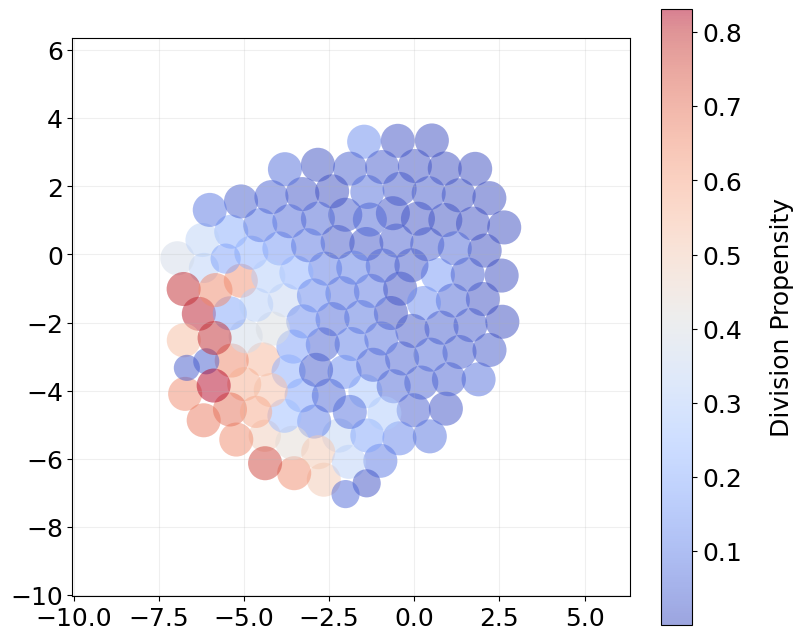

In [10]:
draw_circles_divrate(s, grid=True);

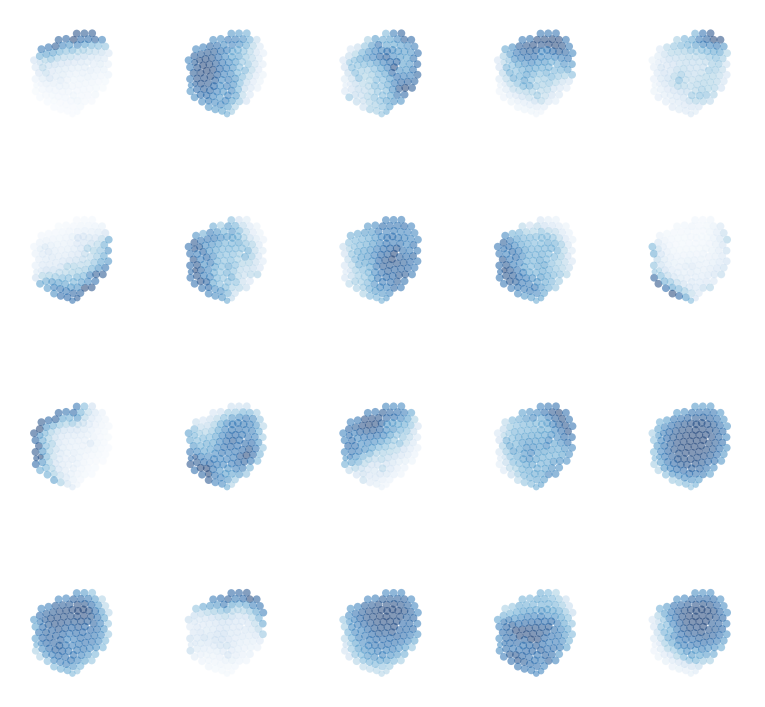

In [11]:
fig, axs = plt.subplots(4, 5)

for i in range(4):
    for j in range(5):
        draw_circles_chem(s, chem=i*5+j, ax=axs[i,j], colorbar=False, cm=plt.cm.Blues)

plt.tight_layout()

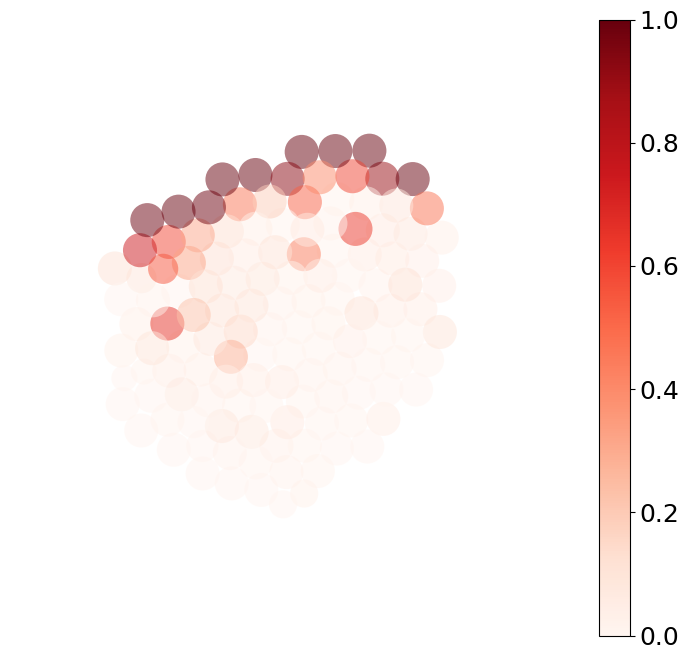

In [12]:
jxm.visualization.draw_circles(s, s.secretion_rate[:,0], cm=plt.cm.Reds);

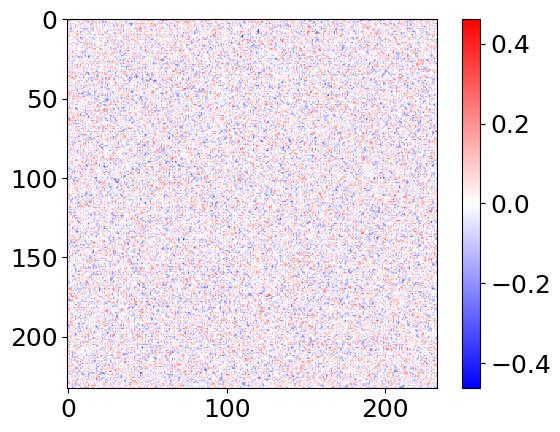

In [13]:
mat = model[-1].interaction_matrix

v = np.max(np.abs(mat))

plt.imshow(mat, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar();

# Optimized Parameters

In [14]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_results.model, istate, subkey, N_ADD)

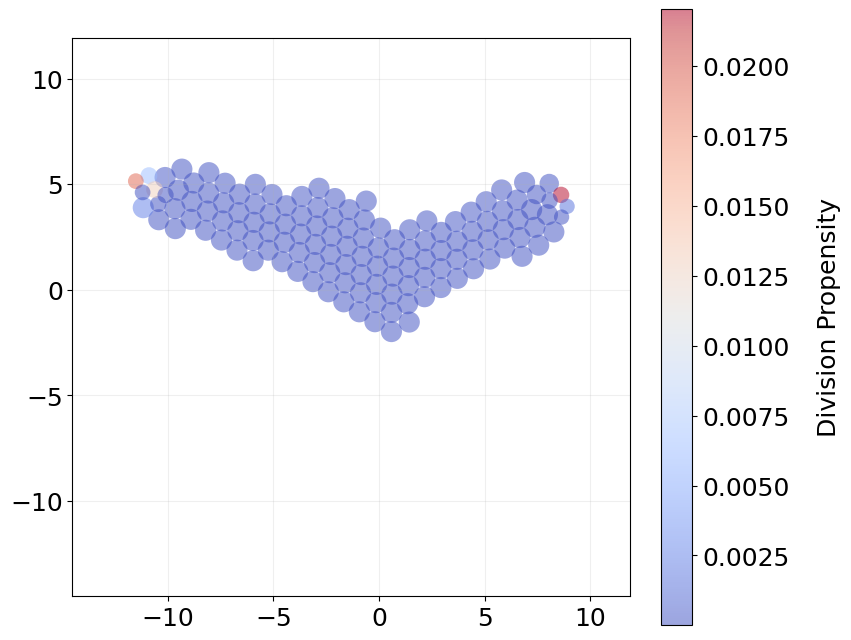

In [15]:
draw_circles_divrate(s, grid=True);

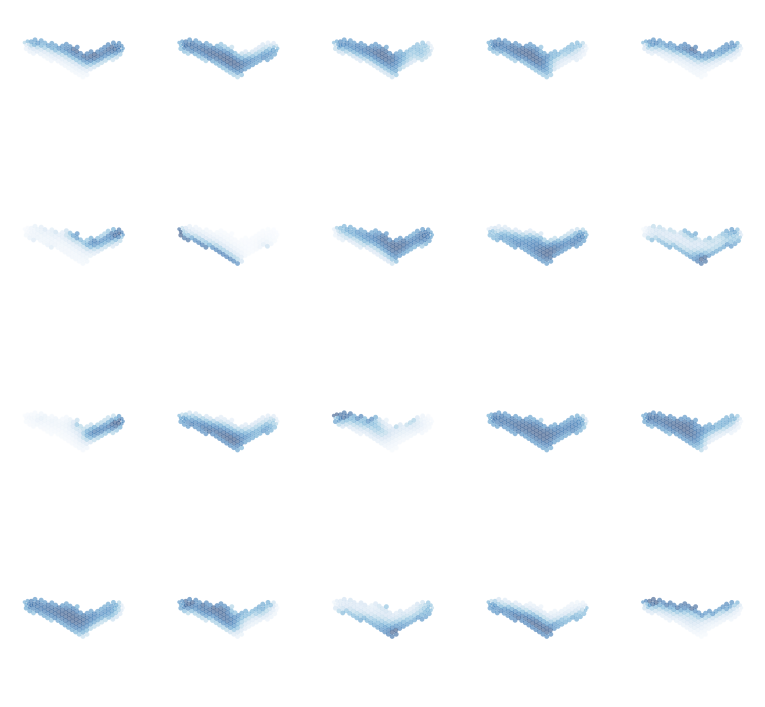

In [16]:
fig, axs = plt.subplots(4, 5)

for i in range(4):
    for j in range(5):
        draw_circles_chem(s, chem=i*5+j, ax=axs[i,j], colorbar=False, cm=plt.cm.Blues)

plt.tight_layout()

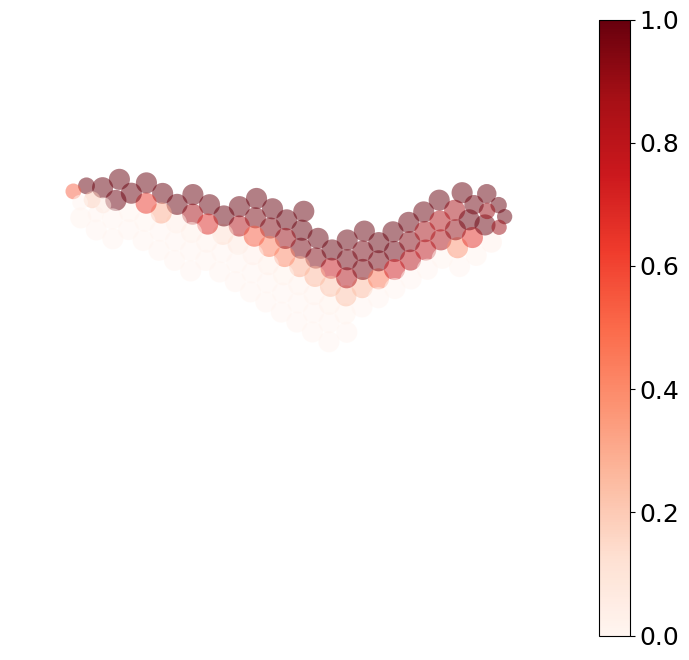

In [17]:
jxm.visualization.draw_circles(s, s.secretion_rate[:,0], cm=plt.cm.Reds);

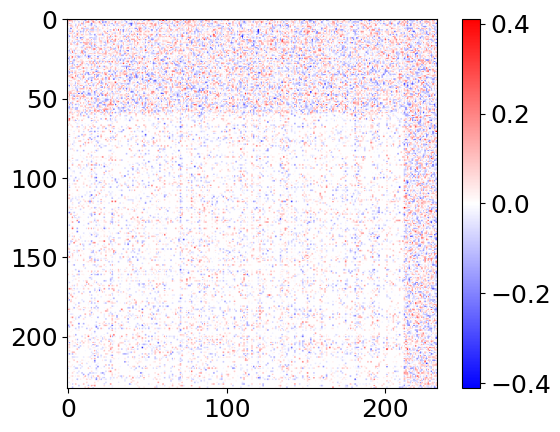

In [18]:
mat = opt_results.model[-1].interaction_matrix

v = np.max(np.abs(mat))

plt.imshow(mat, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar();